In [1]:
# this is MuZero on Tic Tac Toe!
# https://arxiv.org/abs/1911.08265
# The MCTS works

In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline
import tensorflow as tf
import numpy as np
import gym
from tqdm import tqdm, trange
import os,sys
sys.path.append(os.getcwd())
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [3]:
# The Tic Tac Toe game

class TicTacToe():
  def __init__(self, state=None):
    self.reset()
    if state is not None:
      self.state = state

  def reset(self):
    self.done = False
    self.state = [0]*11
    self.state[-1] = 1
    return self.state
   
  class observation_space():
    shape = (11,)

  class action_space():
    n = 9

  def render(self):
    print("turn %d" % self.state[-1])
    print(np.array(self.state[0:9]).reshape(3,3))
    
  def value(self, s):
    ret = 0
    for turn in [-1, 1]:
      for i in range(3):
        if all([x==turn for x in s[3*i:3*i+3]]):
          ret = turn
        if all([x==turn for x in [s[i], s[3+i], s[6+i]]]):
          ret = turn
      if all([x==turn for x in [s[0], s[4], s[8]]]):
        ret = turn
      if all([x==turn for x in [s[2], s[4], s[6]]]):
        ret = turn
    # NOTE: this is not the value, the state may be won
    return ret*s[-1]
  
  def dynamics(self, s, act):
    rew = 0
    s = s.copy()
    if s[act] != 0 or s[-2] != 0:
      # don't move in taken spots or in finished games
      rew = -10
    else:
      s[act] = s[-1]
      rew += self.value(s)
    if s[-2] != 0:
      rew = 0
    else:
      s[-2] = self.value(s)
    s[-1] = -s[-1]
    return rew, s
  
  def step(self, act):
    rew, self.state = self.dynamics(self.state, act)
    if rew != 0:
      self.done = True
    if np.all(np.array(self.state[0:9]) != 0):
      self.done = True
    return self.state, rew, self.done, None
  
# Play a quick round
env = TicTacToe()
print(env.reset())
print(env.step(4))
print(env.step(0))
print(env.step(3))
print(env.step(1))
print(env.step(6))
print(env.step(2))
print(env.state[-1], env.value(env.state))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, -1], 0, False, None)
([-1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], 0, False, None)
([-1, 0, 0, 1, 1, 0, 0, 0, 0, 0, -1], 0, False, None)
([-1, -1, 0, 1, 1, 0, 0, 0, 0, 0, 1], 0, False, None)
([-1, -1, 0, 1, 1, 0, 1, 0, 0, 0, -1], 0, False, None)
([-1, -1, -1, 1, 1, 0, 1, 0, 0, 1, 1], 1, True, None)
1 -1


In [4]:
# a mock representation, dynamics, and prediction function
class MockModel():
  def ht(self,s):
    return s
  def gt(self, s, a):
    #print(s, a)
    return env.dynamics(s,a)
  def ft(self,s):
    #print(s, env.value(s))
    return np.array([1/9]*9), env.value(s)

# unit tests for the MCTS!
from muzero.mcts import mcts_search, print_tree
mm = MockModel()
obs = [1, -1, 1, -1, 1, -1, 0, 0, 0,  0,1]
policy, node = mcts_search(mm, obs, 1000)
print(policy)
act = np.random.choice(list(range(len(policy))), p=policy)
assert act == 8 or act == 6
obs = [-1, -1, 0, 1, 1, 0, 1, 0, 0,  0,-1]
policy, node = mcts_search(mm, obs, 1000)
print(policy)
act = np.random.choice(list(range(len(policy))), p=policy)
assert act == 2
obs = [1,0,0,1,-1,0,-1,0,0,   0,1]
policy, node = mcts_search(mm, obs, 1000)
print(policy)
act = np.random.choice(list(range(len(policy))), p=policy)
assert act == 2
obs = [0,1,-1,0,1,0,0,0,0,  0,-1]
policy, node = mcts_search(mm, obs, 1000)
print(policy)
act = np.random.choice(list(range(len(policy))), p=policy)
assert act == 7
obs = [0,0,0, 0,-1,0, 1,-1,1,  0,1]
policy, node = mcts_search(mm, obs, 1000)
print(policy)
act = np.random.choice(list(range(len(policy))), p=policy)
assert act == 1

[0.         0.         0.         0.         0.         0.
 0.00033535 0.         0.99966465]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
# computer can play against itself...and tie!

gg = TicTacToe()
done = False
while not done:
  policy, node = mcts_search(mm, gg.state, 2000)
  print(policy)
  act = np.random.choice(list(range(len(policy))), p=policy)
  print(act)
  _, _, done, _ = gg.step(act)
  gg.render()

[1. 0. 0. 0. 0. 0. 0. 0. 0.]
0
turn -1
[[1 0 0]
 [0 0 0]
 [0 0 0]]
[0. 0. 0. 0. 0. 0. 1. 0. 0.]
6
turn 1
[[ 1  0  0]
 [ 0  0  0]
 [-1  0  0]]
[0. 0. 0. 0. 0. 0. 0. 1. 0.]
7
turn -1
[[ 1  0  0]
 [ 0  0  0]
 [-1  1  0]]
[0. 0. 0. 0. 0. 0. 0. 0. 1.]
8
turn 1
[[ 1  0  0]
 [ 0  0  0]
 [-1  1 -1]]
[0. 0. 0. 0. 0. 1. 0. 0. 0.]
5
turn -1
[[ 1  0  0]
 [ 0  0  1]
 [-1  1 -1]]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
1
turn 1
[[ 1 -1  0]
 [ 0  0  1]
 [-1  1 -1]]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
2
turn -1
[[ 1 -1  1]
 [ 0  0  1]
 [-1  1 -1]]
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
4
turn 1
[[ 1 -1  1]
 [ 0 -1  1]
 [-1  1 -1]]
[0. 0. 0. 1. 0. 0. 0. 0. 0.]
3
turn -1
[[ 1 -1  1]
 [ 1 -1  1]
 [-1  1 -1]]


In [6]:
# Now we try to learn a model, and things work less well

from muzero.model import MuModel
m = MuModel(env.observation_space.shape, env.action_space.n, s_dim=64, K=5, lr=0.001)
print(env.observation_space.shape, env.action_space.n)

from muzero.game import Game, ReplayBuffer
from muzero.mcts import naive_search, mcts_search
replay_buffer = ReplayBuffer(200, 16, m.K)
rews = []

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(11,) 9


In [7]:
def play_game(env, m):
  import random
  game = Game(env, discount=0.99)
  while not game.terminal():
    # TODO: Do we need to limit the depth of the MCTS search?
    #policy = naive_search(m, game.observation, T=1)
    policy, _ = mcts_search(m, game.observation, 30)
    game.act_with_policy(policy)
  return game

In [8]:
from muzero.model import reformat_batch
import collections

for j in range(30):
  game = play_game(env, m)
  replay_buffer.save_game(game)
  for i in range(20):
    m.train_on_batch(replay_buffer.sample_batch())
  rew = sum(game.rewards)
  rews.append(rew)
  print(len(game.history), rew, game.history, m.losses[-1][0])

2 -10 [4, 4] 5.3141327
4 -10 [8, 5, 6, 5] 64.46634
4 -10 [8, 6, 4, 6] 109.44394
4 -10 [4, 6, 5, 6] 79.12269
4 -10 [8, 6, 5, 6] 117.92034
4 -10 [4, 6, 8, 6] 137.791
6 -10 [0, 7, 1, 8, 3, 8] 228.86325
3 -10 [0, 5, 5] 178.95453
5 -10 [3, 1, 2, 6, 2] 140.30872
3 -10 [1, 7, 7] 170.76105
2 -10 [6, 6] 154.14026
4 -10 [4, 6, 5, 6] 142.79263
2 -10 [5, 5] 149.86656
3 -10 [7, 6, 7] 592.29877
6 -10 [5, 2, 6, 0, 7, 5] 221.93646
2 -10 [2, 2] 167.05666
5 1 [8, 3, 6, 0, 7] 150.44774
4 -10 [3, 5, 2, 3] 142.98276
4 -10 [3, 6, 5, 3] 151.6984
4 -10 [3, 6, 0, 0] 137.26353
2 -10 [6, 6] 127.44191
5 1 [2, 6, 8, 3, 5] 174.89452
4 -10 [0, 6, 3, 6] 1299.0835
4 -10 [8, 3, 4, 8] 362.81866
4 -10 [5, 1, 0, 1] 205.2476
3 -10 [6, 5, 6] 162.90738
6 -10 [5, 2, 3, 6, 8, 8] 146.33574
4 -10 [0, 5, 6, 5] 173.46304
4 -10 [7, 6, 2, 6] 159.79738
4 -10 [1, 6, 4, 6] 183.58522


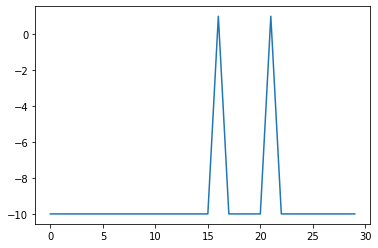

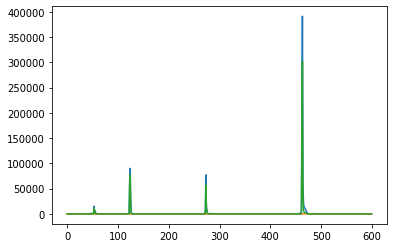

In [12]:
plot(rews)
figure()
plot([x[0] for x in m.losses])
plot([x[1] for x in m.losses])
plot([x[-3] for x in m.losses])

In [9]:
# show starting policy

obs = [0,0,0,0,0,0,0,0,0,  0,1]
policy, value = m.ft(m.ht(obs))
np.reshape(policy, (3,3))

array([[0.0513851 , 0.02443472, 0.07519621],
       [0.16723773, 0.10752013, 0.14870928],
       [0.13597797, 0.1101034 , 0.17943546]], dtype=float32)

In [10]:
# test a "challenging" scenario

obs = [1, -1, 1, -1, 1, -1, 0, 0, 0,  0,1]
TicTacToe(obs).render()
policy, value = m.ft(m.ht(obs))

# expect 6 and 8 to light up in reward...they don't
rew = [m.gt(m.ht(obs), i)[0] for i in range(9)]
np.reshape(policy, (3,3)), np.reshape(rew, (3,3))

turn 1
[[ 1 -1  1]
 [-1  1 -1]
 [ 0  0  0]]


(array([[0.0365698 , 0.03462234, 0.07436159],
        [0.18296465, 0.091771  , 0.11462648],
        [0.14332601, 0.13091904, 0.19083901]], dtype=float32),
 array([[-1.9384444, -1.7125351, -1.7163184],
        [-1.885684 , -1.9812845, -1.9258984],
        [-2.026409 , -1.7050903, -1.9425305]], dtype=float32))